<h1 style="color:#2e86c1; background-color:#f0f0f0; padding:15px; border-radius:15px; text-align:center; font-family:Arial, sans-serif;">
  004 Reinforcement Learning
</h1>

Este archivo Jupyter Notebook presenta el desarrollo de un entorno de aprendizaje por refuerzo aplicado al trading financiero. El objetivo principal es diseñar y entrenar un agente capaz de tomar decisiones de compra, venta o mantenimiento de activos financieros en un entorno simulado, utilizando indicadores técnicos seleccionados estratégicamente.

# Importar librerías

In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm

Descarga y procesamiento de datos históricos: se obtienen los precios de cierre, se calculan los rendimientos logarítmicos y se normalizan para su uso en un modelo GAN.

In [1]:
# Descargar los datos de precios históricos
def download_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data[['Close']]
    return data

# Calcular rendimientos logarítmicos
def calculate_returns(data):
    returns = np.log(data / data.shift(1)).dropna()
    return returns

# Normalizar los rendimientos --- (datos -media)/ desviacion estandar 
def normalize_returns(returns):
    mean = returns.mean()
    std_dev = returns.std()
    returns_norm = (returns - mean) / std_dev
    return returns_norm

# Descargar y procesar los datos
ticker = 'NVDA'
start_date = '2014-11-01'
end_date = '2024-11-01'
data = download_data(ticker, start_date, end_date)
returns = calculate_returns(data)
returns_norm = normalize_returns(returns)
x_train_norm = returns_norm.values  # Convertimos a valores numpy para el GAN

[*********************100%***********************]  1 of 1 completed


Construcción del Generador y Discriminador para el modelo GAN: el generador toma un vector de ruido aleatorio (latent_dim) y genera secuencias simuladas de datos (seq_len). El discriminador evalúa estas secuencias, distinguiendo entre datos reales y generados.


In [2]:
# Generador

#latent_dim es el vector de ruido conjunto de numeros aleatorios que el generador usa para produccir secuencia
# seq_len es la longuitud dr la secuencia de salida cuantos datos queremos generar en cada secuencia

def build_generator(latent_dim=300, seq_len=252):
    model = models.Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(256, activation='relu'),
         layers.Dense(256, activation='relu'),
        layers.Dense(seq_len, activation='linear')  # Salida con una característica por paso
    ])
    return model


# Discriminador (Critic)
def build_discriminator(seq_len=252):
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_shape=(seq_len,1)),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='linear')  # Salida lineal para WGAN
    ])
    return model

# Instanciar modelos
latent_dim = 300
seq_len = 252 
generator = build_generator(latent_dim=latent_dim, seq_len=seq_len)
discriminator = build_discriminator(seq_len=252)


C:\Users\cvple\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [3]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          77,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 252)                 │          64,764 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 207,612 (810.98 KB)

 Trainable params: 207,612 (810.98 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamiento del modelo GAN: se configura un optimizador Adam para el generador y el discriminador, se define el procedimiento de entrenamiento por pasos con cálculo de pérdidas y gradientes, y se ejecuta el entrenamiento por múltiples épocas. El discriminador utiliza clipping de pesos para estabilizar el entrenamiento y las pérdidas de cada iteración se almacenan para análisis posterior.


In [5]:
gen_loss_history = []
disc_loss_history = []


# Optimizer------ ADAM
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)


@tf.function
def train_step(real_data, generator, discriminator, batch_size=100, clip_value=1):
    noise = tf.random.normal([batch_size, generator.input_shape[-1]])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generar datos falsos
        generated_data = generator(noise, training=True)

        # Predicciones del discriminador
        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)

        # Calcular pérdidas
        gen_loss = -tf.reduce_mean(fake_output)
        disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

    # Calcular gradientes
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Aplicar gradientes
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Clipping de pesos para el discriminador (critic)
    for var in discriminator.trainable_variables:
        var.assign(tf.clip_by_value(var, -clip_value, clip_value))

    return gen_loss, disc_loss

# Entrenar por varias épocas
epochs = 1000
num_batches = (len(x_train_norm) // 252) -1
for epoch in range(epochs):
    for batch in range(num_batches):
        batch = x_train_norm[batch*252:(batch+1)*252]
        gen_loss, disc_loss = train_step(batch, generator, discriminator)
        gen_loss_history.append(gen_loss)
        disc_loss_history.append(disc_loss)

    # Cada ciertas iteraciones, imprime las pérdidas
    print(f"Epoch {epoch}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}")


Epoch 0, Gen Loss: -0.04410768672823906, Disc Loss: -0.057256776839494705
Epoch 1, Gen Loss: -0.09251516312360764, Disc Loss: -0.08419715613126755
Epoch 2, Gen Loss: -0.14411677420139313, Disc Loss: -0.07648012042045593
Epoch 3, Gen Loss: -0.1833949089050293, Disc Loss: -0.03391575813293457
Epoch 4, Gen Loss: -0.1625038981437683, Disc Loss: 0.005198359489440918
Epoch 5, Gen Loss: -0.08298072218894958, Disc Loss: 0.015981093049049377
Epoch 6, Gen Loss: 0.04055805131793022, Disc Loss: -0.01829155534505844
Epoch 7, Gen Loss: 0.15548117458820343, Disc Loss: -0.059748366475105286
Epoch 8, Gen Loss: 0.23907087743282318, Disc Loss: -0.07150733470916748
Epoch 9, Gen Loss: 0.2758369743824005, Disc Loss: -0.03782030940055847
Epoch 10, Gen Loss: 0.2571276128292084, Disc Loss: 0.045424193143844604
Epoch 11, Gen Loss: 0.2224741280078888, Disc Loss: 0.13410139083862305
Epoch 12, Gen Loss: 0.17653727531433105, Disc Loss: 0.21195021271705627
Epoch 13, Gen Loss: 0.13193023204803467, Disc Loss: 0.259521

Se configuran los parámetros clave, como el número de escenarios, la longitud de cada secuencia y la dimensión del vector latente. Usando el historial de precios como semilla inicial y un vector de ruido aleatorio, el generador crea escenarios simulados de datos, que se almacenan en un arreglo para análisis y backtesting posterior.

In [6]:
# Configuración de los parámetros
num_scenarios = 1000         # Número de escenarios a generar
seq_len = 252               # Longitud de cada escenario (1 año de días hábiles de mercado)
latent_dim = 300            # Dimensión del vector latente
data_points = len(data)     # Total de puntos de datos disponibles en el historial

# Inicialización de escenarios
scenarios = []

for _ in range(num_scenarios):
    # Seleccionar un punto de inicio aleatorio del historial de precios
    start_index = np.random.choice(data_points - seq_len)  # Asegura que haya datos suficientes para la longitud de la secuencia
    initial_seed = returns_norm.values[start_index:start_index + seq_len]  # Extraer la semilla de longitud seq_len

    # Generar el vector de ruido para el generador
    noise = tf.random.normal([1, latent_dim])

    # Crear el escenario con el generador usando la semilla inicial
    generated_scenario = generator(noise, training=False).numpy().flatten()
    
    # Agregar el escenario generado a la lista de escenarios
    scenarios.append(generated_scenario)

# Convertir escenarios en un arreglo de NumPy para facilitar el backtesting
scenarios_array = np.array(scenarios)  # Shape: (100, 252)
scenarios_array

array([[ 0.23442863,  0.20456457,  0.9791686 , ...,  0.58960485,
         0.4384765 ,  0.3416864 ],
       [-0.00918532,  0.16009426,  0.82753253, ...,  0.6167684 ,
         0.66110575,  0.44037852],
       [ 0.24924052,  0.320747  ,  0.5039464 , ...,  0.47622404,
         0.31677812,  0.40866977],
       ...,
       [ 0.16822834,  0.20296565,  1.3120365 , ...,  0.6743049 ,
         0.70375174,  0.70274776],
       [ 0.0609793 ,  0.2396045 ,  0.80085456, ...,  0.68433404,
         0.6240318 ,  0.71990836],
       [ 0.13778782, -0.11351981,  0.6066758 , ...,  0.56612635,
         0.46589667,  0.54098284]], dtype=float32)

In [8]:
# Configuración de los parámetros
num_scenarios = 1000         # Número de escenarios a generar
seq_len = 252               # Longitud de cada escenario (1 año de días hábiles de mercado)
latent_dim = 300            # Dimensión del vector latente
data_points = len(data)     # Total de puntos de datos disponibles en el historial

# Inicialización de escenarios
scenarios = []

for _ in range(num_scenarios):
    # Seleccionar un punto de inicio aleatorio del historial de precios
    start_index = np.random.choice(data_points - seq_len)  # Asegura que haya datos suficientes para la longitud de la secuencia
    initial_seed = returns_norm.values[start_index:start_index + seq_len]  # Extraer la semilla de longitud seq_len

    # Generar el vector de ruido para el generador
    noise = tf.random.normal([1, latent_dim])

    # Crear el escenario con el generador usando la semilla inicial
    generated_scenario = generator(noise, training=False).numpy().flatten()
    
    # Agregar el escenario generado a la lista de escenarios
    scenarios.append(generated_scenario)

# Convertir escenarios en un arreglo de NumPy para facilitar el backtesting
scenarios_array = np.array(scenarios)  # Shape: (100, 252)
scenarios_array

array([[ 0.22227475,  0.03998692,  0.55466664, ...,  0.45769095,
         0.29327288,  0.12064957],
       [ 0.10717152,  0.35680014,  0.7349191 , ...,  0.5772126 ,
         0.54849935,  0.47200578],
       [ 0.3573773 , -0.11201011,  0.6789251 , ...,  0.3189589 ,
         0.43151715,  0.10529419],
       ...,
       [-0.05297941,  0.3390818 ,  0.5997365 , ...,  0.46026394,
         0.2699714 ,  0.36197564],
       [ 0.24521556,  0.08810423,  1.0323919 , ...,  1.2412475 ,
         0.98943347,  0.2991625 ],
       [ 0.3690413 ,  0.28321633,  0.8974932 , ...,  0.44534037,
         0.4887997 ,  0.33020675]], dtype=float32)

Visualización de escenarios simulados: se grafican hasta 100 escenarios sintéticos generados por el modelo GAN, cada uno con 252 puntos (representando días hábiles del mercado). La gráfica muestra los rendimientos simulados para analizar la diversidad y realismo de los datos generados.


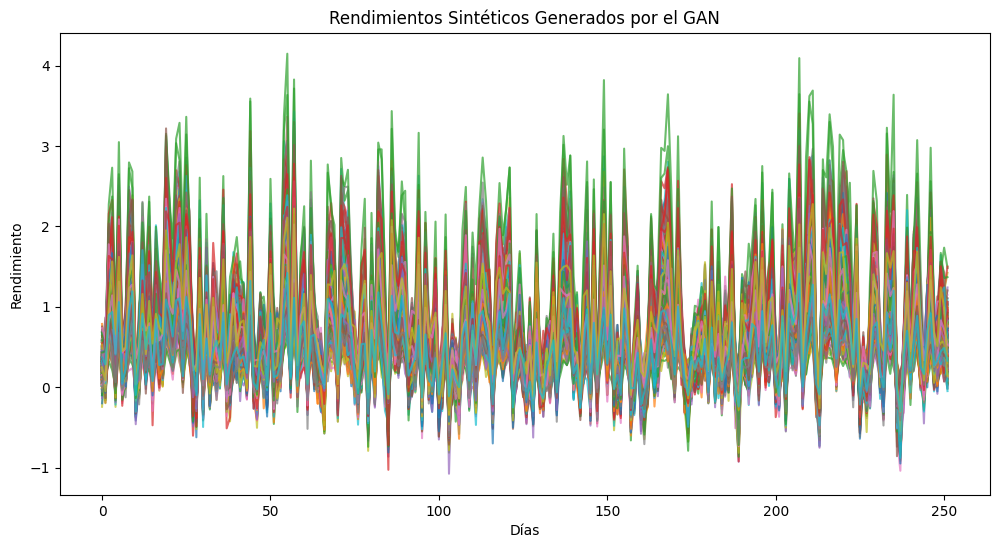

In [9]:
# Generar datos simulados de `scenarios_array` para 100 escenarios, cada uno con 252 puntos
num_scenarios = 1000
seq_len = 252

# Graficar algunos de los escenarios sinteticos
plt.figure(figsize=(12, 6))
for i in range(min(num_scenarios, 1000)):  # Graficamos solo 100 escenarios para mayor claridad
    plt.plot(scenarios_array[i], alpha=0.7, label=f"Escenario {i+1}")

plt.title("Rendimientos Sintéticos Generados por el GAN")
plt.xlabel("Días")
plt.ylabel("Rendimiento")
plt.show()

Desnormalización de rendimientos: se define una función para convertir los rendimientos generados desde su forma normalizada a valores reales, utilizando la media y desviación estándar de los rendimientos originales calculados previamente.

In [10]:
# Desnormalización de los rendimientos generados
def denormalize_returns(normalized_returns, mean, std_dev):
    return (normalized_returns * std_dev) + mean

# Calcular la media y desviación estándar de los rendimientos originales
mean_return = returns.mean().values[0]
std_dev_return = returns.std().values[0]

Simulación de trayectorias de precios: se desnormalizan los rendimientos generados para cada escenario, se acumulan para calcular trayectorias de precios partiendo de un precio inicial, y se almacenan junto con la serie original en un DataFrame. Este DataFrame incluye fechas de días hábiles y permite analizar y comparar la evolución de precios simulados frente a los datos reales.

In [12]:
# Supongamos que tienes la serie original y el precio inicial
original_data = data.Close.NVDA.values[:252]  # Serie original de precios
initial_price = original_data[0]  # Precio inicial de 2024

# Crear una lista para almacenar cada serie simulada
num_scenarios = 1000  # Número de escenarios que quieres simular
simulated_paths = []

for i in range(num_scenarios):
    # Desnormalizar los retornos generados para cada escenario
    denormalized_returns = denormalize_returns(scenarios_array[i], mean_return, std_dev_return)
    # Acumular rendimientos para simular precios y partir desde el precio inicial
    simulated_path = initial_price * np.exp(np.cumsum(denormalized_returns))
    simulated_paths.append(simulated_path)

# Crear un diccionario para las columnas del DataFrame
data_dict = {
    'Fecha': pd.date_range(start='2024-01-01', periods=len(original_data), freq='B'),  # Fechas de días hábiles
    'Serie Original': original_data
}

# Añadir cada serie simulada al diccionario
for i in range(num_scenarios):
    data_dict[f'Serie Simulada {i+1}'] = simulated_paths[i]

# Crear el DataFrame con todas las series
df = pd.DataFrame(data_dict)

# Establecer la columna de fechas como índice (opcional)
df.set_index('Fecha', inplace=True)

# Mostrar el DataFrame
df

,Serie Original,Serie Simulada 1,Serie Simulada 2,Serie Simulada 3,Serie Simulada 4,Serie Simulada 5,Serie Simulada 6,Serie Simulada 7,Serie Simulada 8,Serie Simulada 9,...,Serie Simulada 991,Serie Simulada 992,Serie Simulada 993,Serie Simulada 994,Serie Simulada 995,Serie Simulada 996,Serie Simulada 997,Serie Simulada 998,Serie Simulada 999,Serie Simulada 1000
Fecha,,,,,,,,,,,,,,,,,,,,,
2024-01-01,0.49675,0.501219,0.499474,0.503274,0.499396,0.499692,0.504635,0.500877,0.502554,0.501934,...,0.499702,0.499352,0.504417,0.503330,0.501087,0.498667,0.498337,0.497057,0.501567,0.503452
2024-01-02,0.50325,0.502943,0.506025,0.502685,0.501981,0.506040,0.511863,0.504282,0.503608,0.505983,...,0.502286,0.503122,0.512331,0.508378,0.508720,0.504696,0.500804,0.503306,0.504026,0.508920
2024-01-03,0.50325,0.512603,0.518569,0.514273,0.517063,0.526588,0.534335,0.524737,0.522301,0.515355,...,0.521853,0.519444,0.534086,0.535335,0.519010,0.518496,0.515669,0.513674,0.521196,0.524110
2024-01-04,0.50550,0.524751,0.528150,0.523811,0.532049,0.548826,0.559719,0.547501,0.540725,0.531716,...,0.550122,0.535213,0.551548,0.562989,0.531511,0.529630,0.535016,0.522570,0.547691,0.540370
2024-01-05,0.49475,0.527452,0.529265,0.523939,0.534827,0.553714,0.565924,0.555458,0.546605,0.533466,...,0.553865,0.543232,0.551553,0.569158,0.535457,0.530980,0.543094,0.524750,0.560030,0.548282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-11,0.71100,14.749076,27.650953,11.252481,26.426092,122.309631,296.940979,453.580505,69.840157,36.366795,...,177.490128,33.837261,115.485779,786.605225,30.568193,24.522749,144.263153,12.096049,433.787811,30.234991
2024-12-12,0.71675,14.817034,28.234190,11.389425,26.735338,124.535957,302.088226,462.960144,70.853027,36.671707,...,179.840775,34.504574,117.690277,802.956909,31.070900,24.961182,146.119263,12.335169,441.561249,30.615894
2024-12-13,0.69200,15.057330,28.796169,11.525592,27.081686,128.192841,315.074768,481.711426,72.894028,37.587456,...,186.258896,35.368790,121.529861,836.491699,31.805555,25.345808,150.175934,12.536194,459.501251,31.100769


Visualización de precios simulados: se grafican los 1000 escenarios simulados con colores distintos utilizando la paleta 'viridis' y un estilo de línea discontinua. La serie original se destaca en color negro con mayor grosor. Esta comparación permite analizar cómo las trayectorias simuladas divergen o convergen respecto a los precios reales, proporcionando una visión clara de la diversidad en los escenarios generados.


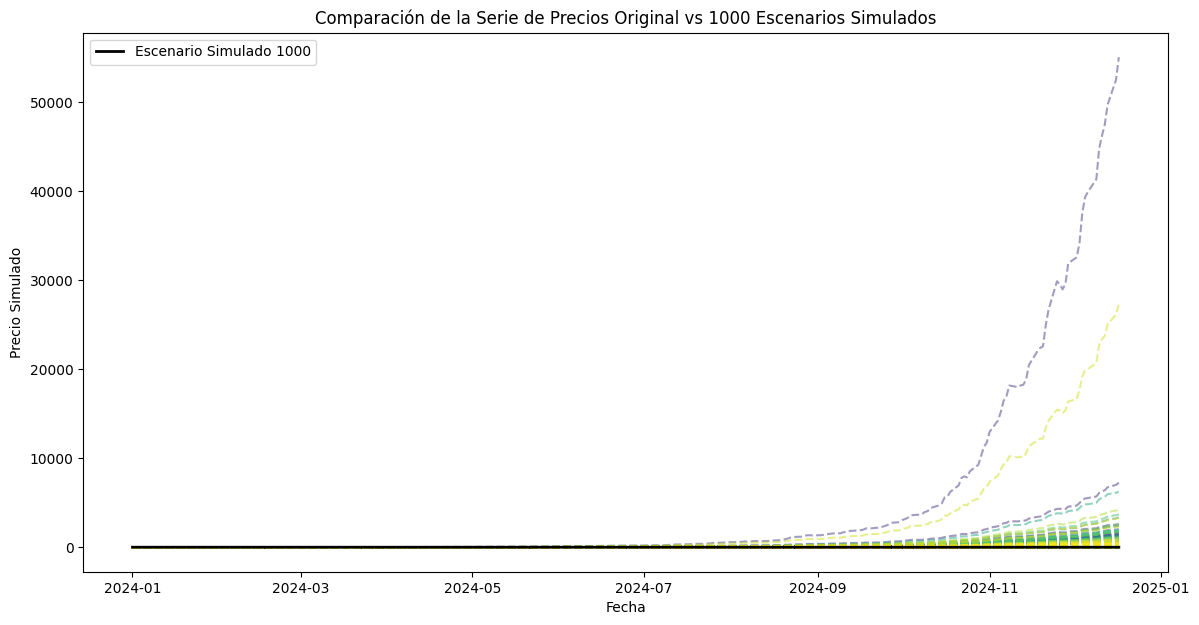

In [14]:
# Crear la figura y configurar el tamaño
plt.figure(figsize=(14, 7))

# Usar la paleta 'viridis' para colores distintos en cada escenario simulado
colors = cm.viridis(np.linspace(0, 1, num_scenarios))

# Graficar cada uno de los 100 escenarios simulados con diferentes colores
for i in range(num_scenarios):
    plt.plot(df.index, df[f'Serie Simulada {i+1}'], alpha=0.5, linestyle="--", color=colors[i])

# Graficar la serie original en color negro y con mayor grosor
plt.plot(df.index, df['Serie Original'], color="black", linewidth=2, label=f"Escenario Simulado {i+1}")

# Configuraciones de la gráfica
plt.title("Comparación de la Serie de Precios Original vs 1000 Escenarios Simulados")
plt.xlabel("Fecha")
plt.ylabel("Precio Simulado")
plt.legend()
plt.show()


In [19]:
data=df

### Cálculo de Indicadores Técnicos y Generación de Señales

Este bloque implementa funciones para calcular los indicadores técnicos **MACD**, **Bandas de Bollinger** y **RSI**, y generar señales de compra y venta basadas en sus valores. Estos indicadores son fundamentales para estrategias de trading.

#### 1. `calculate_macd(series)`
- **Propósito:** Calcular el MACD y las señales de compra/venta.
- **Proceso:**
  - EMA rápida (3 períodos) y EMA lenta (6 períodos).
  - Línea MACD: EMA rápida - EMA lenta.
  - Línea de señal: EMA de la línea MACD (9 períodos).
  - **Señales:** 
    - Compra: MACD cruza hacia arriba la línea de señal.
    - Venta: MACD cruza hacia abajo la línea de señal.

#### 2. `calculate_bollinger_bands(series)`
- **Propósito:** Calcular las Bandas de Bollinger y generar señales.
- **Proceso:**
  - SMA (2 períodos) y desviación estándar (2 períodos).
  - Bandas:
    - Superior: SMA + (0.5 * desviación estándar).
    - Inferior: SMA - (0.5 * desviación estándar).
  - **Señales:** 
    - Compra: Precio < banda inferior.
    - Venta: Precio > banda superior.

#### 3. `calculate_rsi(series)`
- **Propósito:** Calcular el RSI y determinar señales.
- **Proceso:**
  - Cambios diarios y medias móviles (14 períodos).
  - RSI: 100 - (100 / (1 + PromedioSubidas / PromedioBajadas)).
  - **Señales:** 
    - Compra: RSI < 94.5.
    - Venta: RSI > 98.5.


In [21]:
def calculate_macd(series):
    # Calcular las EMAs para la línea MACD
    exp1 = series.ewm(span=3, adjust=False).mean()  # EMA rápida
    exp2 = series.ewm(span=6, adjust=False).mean()  # EMA lenta

    # Calcular la línea MACD y la línea de señal
    macd = exp1 - exp2
    signal_line = macd.ewm(span=9, adjust=False).mean()

    # Determinar las señales de compra y venta
    buy_signal = (macd > signal_line) & (macd.shift(1) < signal_line.shift(1))
    sell_signal = (macd < signal_line) & (macd.shift(1) > signal_line.shift(1))
    
    return buy_signal, sell_signal

def calculate_bollinger_bands(series):
    # Calcular las Bandas de Bollinger
    sma = series.rolling(window=2).mean()
    sd = series.rolling(window=2).std()
    upper_band = sma + (0.5 * sd)
    lower_band = sma - (0.5 * sd)

    # Generar señales de compra y venta
    buy_signal = (series < lower_band)
    sell_signal = (series > upper_band)
    
    return buy_signal, sell_signal

def calculate_rsi(series):
    # Calcular el cambio diario de los precios
    change = series.diff()
    change_up = change.clip(lower=0)
    change_down = -change.clip(upper=0)

    # Calcular la media móvil de los cambios positivos y negativos
    avg_up = change_up.rolling(window=14).mean()
    avg_down = change_down.rolling(window=14).mean()

    # Calcular el RSI
    rsi = 100 - (100 / (1 + (avg_up / avg_down)))

    # Generar señales de compra y venta basadas en RSI
    buy_signal_rsi = (rsi < 94.5)
    sell_signal_rsi = (rsi > 98.5)
    
    return buy_signal_rsi, sell_signal_rsi


### Implementación de un Entorno de Trading con Gymnasium

En esta sección se desarrolla un entorno de trading utilizando la biblioteca **Gymnasium**, con el objetivo de simular interacciones del mercado y permitir el entrenamiento de agentes de aprendizaje por refuerzo. El entorno sigue un diseño estándar, incorporando acciones, estados y recompensas específicas del mercado financiero.

#### Principales características

1. **Clase `TradingEnv`:**
   - **Datos y configuración inicial:**
     - Utiliza precios históricos simulados como entrada (`data`).
     - Configura variables iniciales, como el balance inicial, la posición máxima permitida y los costos de transacción.
   - **Espacio de acciones:**
     - Contiene tres posibles acciones:
       - 0: Mantener la posición.
       - 1: Comprar.
       - 2: Vender.
   - **Espacio de observaciones:**
     - Incluye las siguientes variables relevantes:
       - Precio actual del activo.
       - Posición actual (cantidad de activos en posesión).
       - Balance de efectivo disponible.
       - Patrimonio neto total.
       - Señales generadas por los indicadores técnicos (MACD, RSI, y Bandas de Bollinger).

2. **Métodos principales:**
   - **`_next_observation`:** Proporciona la observación actual, incluyendo precio, balance, posición y señales de indicadores técnicos.
   - **`step(action)`:** Realiza la acción seleccionada (comprar, vender o mantener), calcula la recompensa correspondiente y avanza al siguiente estado.
     - **Recompensas:** Basadas en ganancias/pérdidas, señales de indicadores técnicos y actividad del agente.
     - **Penalizaciones:** Por inactividad en presencia de señales fuertes o por pérdidas en el patrimonio neto.
   - **`reset`:** Reinicia el entorno al estado inicial para comenzar una nueva simulación.
   - **`render`:** Muestra el estado actual del entorno (precio, balance, posición, y patrimonio neto).

3. **Interacción con el entorno:**
   - Se utiliza el método `step` para interactuar con el entorno y simular decisiones de trading.
   - Las recompensas y penalizaciones están diseñadas para incentivar al agente a tomar decisiones que maximizan el patrimonio neto.

#### Propósito
Este entorno es fundamental para entrenar agentes de aprendizaje por refuerzo, permitiendo probar estrategias de trading basadas en acciones secuenciales y el uso de indicadores técnicos. La estructura sigue los estándares de Gymnasium, facilitando la integración con algoritmos de aprendizaje ya existentes.


In [23]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np


class TradingEnv(gym.Env):
    def __init__(self, data, initial_balance=1000000, max_position=1000, transaction_cost=0.25):
        super(TradingEnv, self).__init__()

        # Datos del entorno (Precios históricos)
        self.data = data  # DataFrame con precios e indicadores
        self.prices = data['Serie Simulada 992'].values  # Precios originales
        self.initial_balance = initial_balance  # Balance inicial
        self.max_position = max_position  # Máxima cantidad de activos permitidos
        self.transaction_cost = transaction_cost  # Costo por transacción

        # Variables del entorno
        self.current_step = 0  # Paso inicial del tiempo
        self.balance = self.initial_balance  # Balance inicial
        self.position = 0  # Activos en posesión al inicio
        self.net_worth = self.initial_balance  # Patrimonio inicial

        # Espacio de acciones: 0 = Mantener, 1 = Comprar, 2 = Vender
        self.action_space = spaces.Discrete(3)

        # Espacio de estados: precio, posición, balance, patrimonio neto y señales de indicadores
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(7,),  # Precio actual, posición, balance, patrimonio neto, MACD, RSI, BB
            dtype=np.float32
        )

        # Calculamos los indicadores técnicos
        self.data['MACD_Buy'], self.data['MACD_Sell'] = calculate_macd(data['Serie Original'])
        self.data['BB_Buy'], self.data['BB_Sell'] = calculate_bollinger_bands(data['Serie Original'])
        self.data['RSI_Buy'], self.data['RSI_Sell'] = calculate_rsi(data['Serie Original'])

    def _next_observation(self):
        # Precio actual
        current_price = self.prices[self.current_step]

        # Señales de los indicadores en el paso actual
        macd_signal = (
            1 if self.data['MACD_Buy'].iloc[self.current_step]
            else -1 if self.data['MACD_Sell'].iloc[self.current_step]
            else 0
        )
        bollinger_signal = (
            1 if self.data['BB_Buy'].iloc[self.current_step]
            else -1 if self.data['BB_Sell'].iloc[self.current_step]
            else 0
        )
        rsi_signal = (
            1 if self.data['RSI_Buy'].iloc[self.current_step]
            else -1 if self.data['RSI_Sell'].iloc[self.current_step]
            else 0
        )

        # Observación como un array
        return np.array([
            current_price,
            self.position,
            self.balance,
            self.net_worth,
            macd_signal,
            bollinger_signal,
            rsi_signal
        ], dtype=np.float32)

    def step(self, action):
        current_price = self.prices[self.current_step]
        done = False
        reward = 0
    
        # Calcular las señales de indicadores técnicos al inicio del paso
        macd_signal = int(self.data['MACD_Buy'].iloc[self.current_step]) - int(self.data['MACD_Sell'].iloc[self.current_step])
        rsi_signal = int(self.data['RSI_Buy'].iloc[self.current_step]) - int(self.data['RSI_Sell'].iloc[self.current_step])
        bb_signal = int(self.data['BB_Buy'].iloc[self.current_step]) - int(self.data['BB_Sell'].iloc[self.current_step])
    
        # Acciones: Comprar, Vender, Mantener
        if action == 1:  # Comprar
            if self.balance >= current_price * 50 and self.position + 50 <= self.max_position:
                self.position += 50  # Comprar 50 unidades
                self.balance -= current_price * 50 * (1 + self.transaction_cost)
                # Bonificación si el precio sube en el siguiente paso
                if self.current_step < len(self.prices) - 1:
                    next_price = self.prices[self.current_step + 1]
                    if next_price > current_price:
                        reward += (next_price - current_price) * 50  # Recompensa proporcional a la ganancia
    
        elif action == 2:  # Vender
            if self.position >= 10:
                self.position -= 10  # Vender 10 unidades
                self.balance += current_price * 10 * (1 - self.transaction_cost)
                # Bonificación si el precio baja en el siguiente paso
                if self.current_step < len(self.prices) - 1:
                    next_price = self.prices[self.current_step + 1]
                    if next_price < current_price:
                        reward += (current_price - next_price) * 10  # Recompensa proporcional a la ganancia
    
        # Penalización por inactividad ajustada al contexto
        elif action == 0:  # Mantener
            # Si no hay señales fuertes, no penalizamos
            if macd_signal == 0 and rsi_signal == 0 and bb_signal == 0:
                reward += 0  # Sin penalización por mantener
            else:
                reward -= 0.001 * self.net_worth  # Penalización leve si hay señales que indican tomar acción
    
        # Bonificación por señales de indicadores técnicos
        if action == 1 and macd_signal == 1:
            reward += 10  # Bonificación por comprar en señal de compra MACD
        elif action == 2 and macd_signal == -1:
            reward += 10  # Bonificación por vender en señal de venta MACD
    
        if action == 1 and rsi_signal == 1:
            reward += 5  # Bonificación por comprar en sobreventa RSI
        elif action == 2 and rsi_signal == -1:
            reward += 5  # Bonificación por vender en sobrecompra RSI
    
        if action == 1 and bb_signal == 1:
            reward += 5  # Bonificación por comprar en soporte BB
        elif action == 2 and bb_signal == -1:
            reward += 5  # Bonificación por vender en resistencia BB
    
        # Calcular el nuevo patrimonio neto
        new_net_worth = self.balance + (self.position * current_price)
    
        # Penalización por reducción en el patrimonio neto
        if new_net_worth < self.net_worth:
            reward -= (self.net_worth - new_net_worth) * 0.1  # Penalización proporcional a la pérdida
    
        self.net_worth = new_net_worth
        self.current_step += 1
        if self.current_step >= len(self.prices) - 1:
            done = True
    
        # Obtener el siguiente estado
        next_state = self._next_observation()
    
        return next_state, reward, done, {}


    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.position = 0
        self.net_worth = self.initial_balance
        return self._next_observation()

    def render(self, mode="human"):
        current_price = self.prices[self.current_step]
        print(f"Step: {self.current_step}")
        print(f"Price: {current_price:.2f}")
        print(f"Balance: {self.balance:.2f}")
        print(f"Position: {self.position}")
        print(f"Net Worth: {self.net_worth:.2f}")

# Crear una instancia del entorno con los datos actualizados
env = TradingEnv(data)

# Ejemplo de interacción
state = env.reset()
done = False
while not done:
    action = env.action_space.sample()  # Selección de acción aleatoria
    next_state, reward, done, info = env.step(action)
    env.render()

Step: 1
Price: 0.50
Balance: 1000000.00
Position: 0
Net Worth: 1000000.00
Step: 2
Price: 0.52
Balance: 999968.55
Position: 50
Net Worth: 999993.71
Step: 3
Price: 0.54
Balance: 999968.55
Position: 50
Net Worth: 999994.53
Step: 4
Price: 0.54
Balance: 999972.57
Position: 40
Net Worth: 999993.98
Step: 5
Price: 0.56
Balance: 999938.62
Position: 90
Net Worth: 999987.51
Step: 6
Price: 0.56
Balance: 999938.62
Position: 90
Net Worth: 999988.86
Step: 7
Price: 0.57
Balance: 999938.62
Position: 90
Net Worth: 999989.20
Step: 8
Price: 0.59
Balance: 999938.62
Position: 90
Net Worth: 999990.06
Step: 9
Price: 0.61
Balance: 999938.62
Position: 90
Net Worth: 999991.47
Step: 10
Price: 0.61
Balance: 999900.53
Position: 140
Net Worth: 999985.84
Step: 11
Price: 0.62
Balance: 999862.32
Position: 190
Net Worth: 999978.47
Step: 12
Price: 0.63
Balance: 999862.32
Position: 190
Net Worth: 999979.79
Step: 13
Price: 0.64
Balance: 999867.08
Position: 180
Net Worth: 999981.09
Step: 14
Price: 0.66
Balance: 999871.90
Po

### Gráficos 

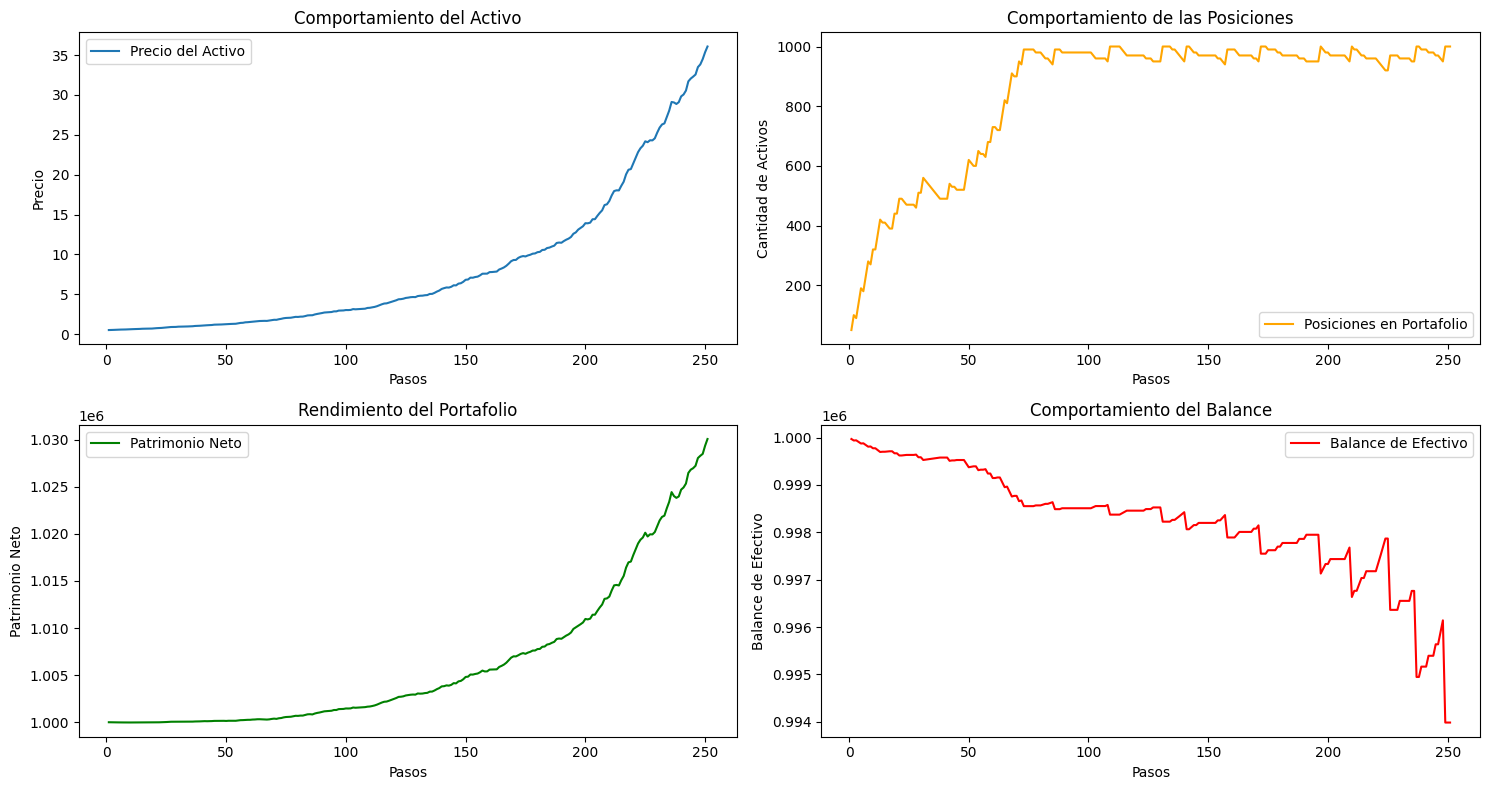

Total de Compras Realizadas: 95
Total de Ventas Realizadas: 80
Valor Final del Portafolio: 1030067.76
Ganancia Total: 30067.76


In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Simulación de interacción con el entorno
env = TradingEnv(data)
state = env.reset()
done = False

# Variables para almacenar los resultados
steps = []
prices = []
positions = []
net_worths = []
balances = []
actions = []

# Ejecución del entorno y registro de datos
while not done:
    action = env.action_space.sample()  # Selección de acción aleatoria
    next_state, reward, done, info = env.step(action)

    # Guardar información del paso actual
    steps.append(env.current_step)
    prices.append(env.prices[env.current_step - 1] if env.current_step > 0 else env.prices[0])
    positions.append(env.position)
    net_worths.append(env.net_worth)
    balances.append(env.balance)
    actions.append(action)

# DataFrame para análisis
results = pd.DataFrame({
    "Step": steps,
    "Price": prices,
    "Position": positions,
    "Net Worth": net_worths,
    "Balance": balances,
    "Action": actions
})

# Gráficos
plt.figure(figsize=(15, 8))

# Gráfico 1: Comportamiento del activo
plt.subplot(2, 2, 1)
plt.plot(results["Step"], results["Price"], label="Precio del Activo")
plt.title("Comportamiento del Activo")
plt.xlabel("Pasos")
plt.ylabel("Precio")
plt.legend()

# Gráfico 2: Comportamiento de las posiciones
plt.subplot(2, 2, 2)
plt.plot(results["Step"], results["Position"], label="Posiciones en Portafolio", color="orange")
plt.title("Comportamiento de las Posiciones")
plt.xlabel("Pasos")
plt.ylabel("Cantidad de Activos")
plt.legend()

# Gráfico 3: Rendimiento del portafolio
plt.subplot(2, 2, 3)
plt.plot(results["Step"], results["Net Worth"], label="Patrimonio Neto", color="green")
plt.title("Rendimiento del Portafolio")
plt.xlabel("Pasos")
plt.ylabel("Patrimonio Neto")
plt.legend()

# Gráfico 4: Balance
plt.subplot(2, 2, 4)
plt.plot(results["Step"], results["Balance"], label="Balance de Efectivo", color="red")
plt.title("Comportamiento del Balance")
plt.xlabel("Pasos")
plt.ylabel("Balance de Efectivo")
plt.legend()

plt.tight_layout()
plt.show()

# Análisis de métricas finales
total_compras = results[results["Action"] == 1].shape[0]
total_ventas = results[results["Action"] == 2].shape[0]
valor_final_portafolio = results["Net Worth"].iloc[-1]
ganancia_total = valor_final_portafolio - env.initial_balance

# Resultados
print(f"Total de Compras Realizadas: {total_compras}")
print(f"Total de Ventas Realizadas: {total_ventas}")
print(f"Valor Final del Portafolio: {valor_final_portafolio:.2f}")
print(f"Ganancia Total: {ganancia_total:.2f}")

### Análisis de los Gráficos Generados

1. **Comportamiento del Activo:**
   - El gráfico muestra un aumento constante en el precio del activo a lo largo de los pasos simulados.
   - Esto indica un mercado en tendencia alcista, lo que puede haber influido en las decisiones de compra del agente.

2. **Comportamiento de las Posiciones:**
   - Observamos un incremento progresivo en la cantidad de activos en el portafolio.
   - Esto sugiere que el agente optó principalmente por realizar compras a medida que los precios subían, maximizando su exposición al mercado alcista.

3. **Rendimiento del Portafolio:**
   - El patrimonio neto sigue una trayectoria ascendente, reflejando un crecimiento constante del portafolio.
   - Este resultado sugiere que las decisiones tomadas, aunque aleatorias, lograron aumentar el valor total del portafolio en el entorno simulado.

4. **Comportamiento del Balance:**
   - El balance de efectivo disminuye a medida que se realizan compras, pero no se recupera completamente debido a la limitada cantidad de ventas realizadas.
   - Hacia el final, el balance muestra una caída abrupta, probablemente vinculada a una gran compra o una pérdida significativa en el portafolio.

### Observaciones Generales:
- El entorno simulado refleja un mercado con tendencias alcistas, lo que favoreció el incremento del patrimonio neto.
- El agente, aunque aleatorio en sus decisiones, parece haber aprovechado la tendencia comprando más activos conforme avanzaba la simulación.
- La caída abrupta en el balance al final de la simulación podría indicar la necesidad de optimizar la gestión del efectivo en futuras estrategias.

Este análisis indica que el modelo está funcionando correctamente para capturar interacciones básicas del mercado y proporciona una base para implementar estrategias más sofisticadas en el futuro.
